**Expectations:** run some stockastic optimisers to fit a linear model on the MNIST data set of hand written digits.


**Note we have swapped from using numpy to torch, the syntax is very similar!**

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler

In [44]:
# GENERATE MNIST DATASET - no need to edit
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader

In [45]:
batch_size = 64 # this is batch size i.e. the number of rows in a batch of data, feel free try other values {32, 64, 128, 256, 512}

input_dimension = 1 * 28 * 28 # MNIST images are grey scale images 28 pixels wide and high
d = input_dimension # if you prefer a shorter varible name

number_of_classes = 10 # number of class of MNIST data set C = {0,1,2,3,4,5,6,7,8,9}

train_loader, valid_loader, test_loader=mnist(batch_size) # Create the data loaders these are objects that when looping over present batchs of data

# lists to store loss and accuracy values
sgd_train_losses, sgd_val_losses, sgd_train_acc, sgd_val_acc = [], [], [], []
opt_train_losses, opt_val_losses, opt_train_acc, opt_val_acc = [], [], [], []
adam_train_losses, adam_val_losses, adam_train_acc, adam_val_acc = [], [], [], []


In [46]:
batch = next(iter(train_loader))
batch_content = batch[0]
print('dimension of single batch: ',batch_content.size())
print('code will convert 28*28 image in a single 784 vector of pixel values on which we will fit a linear model')

dimension of single batch:  torch.Size([64, 1, 28, 28])
code will convert 28*28 image in a single 784 vector of pixel values on which we will fit a linear model


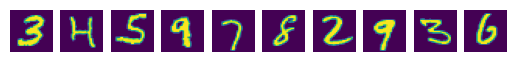

In [47]:
# Visulise some training examples
k = 0
h = 10
f, axs = plt.subplots(1,h)

for k in range(h):
  img = batch_content[k,:,:,:].squeeze()
  axs[k].imshow(img)
  axs[k].axis("off")

**Loss Function** for mnist digits we will use the cross entropy loss:

\begin{align*}
\text{Cross Entropy Loss} : \frac{1}{N}\sum_{z=1}^N \ell_{z}(\mathbf{y}_{z},\mathbf{y}_z^*) = - \frac{1}{N}\sum_{z=1}^N\sum_{c \in C}y^*_{z,c} \text{log}(y_{z,c}) = - \frac{1}{N}\sum_{z=1}^N\mathbf{y}^*_{z} \text{log}(\text{softmax}(\mathbf{x}_z \mathbf{w})^\top)
\end{align*}

where $y^*_z$ is $c_z^{th}$ unit vector corresponding were $c_z$ is the class of the $z^{th}$ training example. For a concrete example is the class of the first example was 0, $y_0^* = [1,0,0,0,0,0,0,0,0,0]$.

\begin{align*}
\text{softmax}(\mathbf{x}) = \frac{\exp{\mathbf{x}}}{\sum_i \exp{x_i}}
\end{align*}

In [48]:
# By default the data loader gives you the class value as a integer rather than a one hot vector as show above

def index_to_one_hot(y, classes=10):
  b = len(y) # batchsize
  one_hot = torch.zeros((b, classes), device=y.device)
  xs = torch.arange(b, device=y.device)
  one_hot[xs,y] = 1
  return one_hot

y = torch.randint(10,(10,))
print('y',y)
print('y',index_to_one_hot(y))

y tensor([6, 6, 9, 7, 6, 4, 1, 9, 1, 2])
y tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


**Question 1** Complete the CE loss function below:

In [49]:
Y = index_to_one_hot(y)
X = torch.randn(10,10)

print(X,Y)

tensor([[-0.2865,  0.8780, -1.2534,  0.5896, -0.6657,  0.6447,  0.3928,  0.6472,
         -0.9583,  0.4300],
        [-0.0273,  0.4928, -0.1495, -1.0287,  1.1264, -1.0580, -1.8654, -0.0971,
         -0.0683, -0.4108],
        [ 1.1883, -2.5846, -0.9248,  1.2552, -1.1997, -1.0292,  0.2223, -0.6692,
         -1.2879,  0.4237],
        [-1.3363,  0.5056, -0.8551, -0.0811,  0.1807, -0.9400,  1.0675, -0.0992,
          0.0222, -0.9218],
        [-2.0912,  1.0832, -1.2710, -0.3550, -0.3002, -1.3745, -1.5836, -0.7946,
          0.1866, -0.3463],
        [-0.8471,  1.7224, -0.8937,  0.6601,  3.1761, -0.8990, -0.4385,  0.2912,
         -0.5341, -1.6423],
        [-1.7059,  1.5361,  0.1380, -0.1282,  1.2865, -1.3954,  0.6354,  0.5182,
         -1.3695,  0.2264],
        [-0.4981, -0.6334,  1.0009,  0.8270,  0.2509,  0.3211,  0.7740, -1.3163,
         -0.8218,  0.3360],
        [-0.2064, -0.2543, -1.0915,  1.3151, -1.1919,  1.0148, -1.0320, -1.5065,
         -1.2468, -1.1798],
        [ 1.5814,  

In [50]:
# As before please complete the following two functions. Remember here X and y are batches of b examples.
import torch.nn.functional as F

def CE_loss(X, ystar, w):
  # ----------------------------
  # your code here
  Softmax = F.softmax(X.matmul(w), dim=1)
  loss = -torch.sum(ystar * torch.log(Softmax)) / X.size(0)
  # ---------------------------
  return float(loss)

In [51]:
Y = index_to_one_hot(y)
X = torch.randn(10,10)

print('your function:',float(CE_loss(X,Y,torch.eye(10).float())))
print('should match this function:',float(F.cross_entropy(X, y)))

your function: 2.6719393730163574
should match this function: 2.6719391345977783


**Question 2** the gradient of the CE loss is

\begin{equation}
  \nabla_\ell(W) = -\frac{1}{N} \sum_{z=1}^N \mathbf{x}_z ( \mathbf{y}^*_{z} - \text{softmax} (W^\top\mathbf{x}_z))
\end{equation}



See if you can derive this,
(**Hint** use the chain rule
$\frac{\partial \ell}{\partial \mathbf{w}_c} = \sum_{z=1}^N \sum_{i=1}^C (\frac{\partial \ell}{\partial \hat{y}_{i,z}} \frac{\partial \hat{y}_{i,z}}{\partial \mathbf{w}_c} )
$, try setting $\hat{y}_{i,z} = \text{softmax}(\mathbf{x}_z \mathbf{w}_i)$)


* A:

$\frac{\partial \ell}{\partial \mathbf{w}_c} = \sum_{z=1}^N \sum_{i=1}^C (\frac{\partial \ell}{\partial \hat{y}_{i,z}} \frac{\partial \hat{y}_{i,z}}{\partial \mathbf{w}_c} )
$ \\

$
\frac{\partial l}{\partial \hat{y}_{z,c}}=-\frac{1}{N} \frac{y^*_{z,c}}{\hat{y}_{z,c}}
$ \\

$
\frac{\partial \hat{y_{z,c}}}{\partial w_k}=\hat{y_{z,c}}(δ_{c,k}-\hat{y}_{z,k})
$ \\

$δ_{c,k}$ is the Kronecker delta which is 1 if c=k and 0 otherwise.

$\frac{\partial \ell}{\partial \mathbf{w}_c}=\sum_{z=1}^N \sum_{i=1}^C (-\frac{1}{N} \frac{y^*_{z,c}}{\hat{y}_{z,c}})(\hat{y_{z,c}}(δ_{c,k}-\hat{y}_{z,k}))
$ \\

Since $y^*_{z,i}$ is 1 only when i is the correct class for example z, the summation over i simplifies, leading to:

$
\frac{\partial \ell}{\partial \mathbf{w}_c} = -\frac{1}{N}{∑^N_{z=1}{x_z (y^*_{z,c}-\hat{y_{z,c}})}}
$

Thus,

\begin{equation}
  \nabla_\ell(W) = -\frac{1}{N} \sum_{z=1}^N \mathbf{x}_z ( \mathbf{y}^*_{z} - \text{softmax} (W^\top\mathbf{x}_z))
\end{equation}



**Question 3** complete the function to calculate the gradient of the CE loss below.


In [52]:
def grad_func(X, ystar, w):
  n = X.size()[0]
  # your code here
  # ----------------------------
  Softmax = F.softmax(X.matmul(w), dim=1)
  error = ystar - Softmax
  #grad = -torch.sum(X*error)/n
  grad = - (X.T.matmul(error)) / n
  # ----------------------------
  return grad

In [53]:
grad_func(X,Y,torch.eye(10).float())

tensor([[ 9.4557e-02,  5.2770e-02,  3.7200e-02,  4.4066e-02,  2.2485e-02,
          2.2651e-02, -2.7016e-01, -2.7461e-02,  4.0862e-02, -1.6966e-02],
        [-1.2728e-02,  1.2941e-02,  1.4671e-01, -1.2172e-02, -7.5088e-02,
         -1.0235e-02, -1.1849e-01, -3.2201e-02, -6.6620e-02,  1.6788e-01],
        [ 1.0100e-01,  2.3374e-02,  4.5375e-02,  5.3365e-02, -1.0055e-01,
          2.6372e-02, -1.5596e-01, -1.3097e-01,  3.4704e-02,  1.0329e-01],
        [ 2.6018e-02, -7.5160e-03,  1.8290e-02,  2.4696e-02, -2.7350e-02,
          9.8239e-04, -8.9147e-02,  6.7325e-02, -2.6859e-03, -1.0614e-02],
        [-3.9055e-02, -3.4748e-01,  4.9605e-02,  1.7081e-02,  3.9862e-02,
          4.8944e-03,  1.3841e-01,  1.6505e-01,  1.7856e-02, -4.6222e-02],
        [-3.6476e-02,  2.0050e-01, -2.1663e-02, -3.8359e-02, -5.1314e-03,
          8.9402e-04, -1.0792e-01, -3.6421e-02, -7.9317e-02,  1.2389e-01],
        [ 2.5635e-02,  7.2531e-02, -1.6386e-01,  4.9615e-03,  1.0184e-01,
         -3.0561e-04,  1.0088e-0

In [54]:
# useful function to calculate accuracy

def accuracy(out, targets):
    _, pred = torch.max(out, 1)
    correct = torch.eq(pred, targets).sum()
    acc = torch.mean(torch.eq(pred, targets).float())
    return correct, float(100. * acc)

In [55]:
def test(w, valid_loader): # function that evaluates loss on vaildation set
    total_loss, total_correct, total_num = 0, 0, 0
    for batch in valid_loader:
      X,y = batch[0].to(device).view(batch[0].size()[0],input_dimension), batch[1].to(device)
      Y = index_to_one_hot(y, classes=10)
      loss_train = CE_loss(X, Y, w)
      correct, acc = accuracy(X.mm(w), y)
      total_correct += correct
      total_loss += loss_train*X.size()[0]
      total_num += X.size()[0]
    return float(total_loss/total_num), float(total_correct/total_num * 100)

**Question 4** implement the SGD with momentum and experiment with with different batch sizes. What do you notice?

In [56]:
with torch.no_grad(): # in this exercise we will not use autograd you will have calculated gradient

  # fixing a device to run the codes on
  device = torch.device("cuda:0")

  w = torch.zeros(input_dimension,number_of_classes).to(device)
  m = torch.zeros(input_dimension,number_of_classes).to(device)

  eta = 1e-1
  num_epochs = 10

  mu = 0.9

  for i in range(num_epochs):
    total_loss, total_correct, total_num = 0, 0, 0
    for batch in train_loader:
      #extractign data and labels from batch
      X,y = batch[0].to(device).view(batch[0].size()[0],input_dimension), batch[1].to(device)
      Y = index_to_one_hot(y, classes=10)
      # ----------------------------
      # Optimisation -  Your code here

      # Iteratively updating momentum velocity and the weights
      m = mu*m - eta*grad_func(X,Y,w)
      w += m

      # ----------------------------
      # track loss and accuracy after every step
      loss_train = CE_loss(X, Y, w)
      correct, acc = accuracy(X.mm(w), y)
      total_correct += correct
      total_loss += loss_train*X.size()[0]
      total_num += X.size()[0]

    # ----------------------------
    # After each epoch track metrics
    sgd_train_losses.append(float(total_loss/total_num))
    sgd_train_acc.append(float(total_correct/total_num * 100))
    val_loss, val_acc = test(w, valid_loader)
    sgd_val_losses.append(val_loss)
    sgd_val_acc.append(val_acc)
    print('train loss: {:.2e} | train acc: {:.2f} | eta: {:.2f}'.format(float(total_loss/total_num), float(total_correct/total_num * 100), eta))
    print('val loss: {:.2e} | val acc: {:.2f}'.format(val_loss, val_acc))
    print('-'*50)
    # ----------------------------
    # Adjust the learning rate
    eta *= 0.9

train loss: 3.63e-01 | train acc: 89.61 | eta: 0.10
val loss: 3.16e-01 | val acc: 90.75
--------------------------------------------------
train loss: 3.02e-01 | train acc: 91.51 | eta: 0.09
val loss: 3.26e-01 | val acc: 90.62
--------------------------------------------------
train loss: 2.91e-01 | train acc: 91.94 | eta: 0.08
val loss: 2.99e-01 | val acc: 91.52
--------------------------------------------------
train loss: 2.81e-01 | train acc: 92.20 | eta: 0.07
val loss: 3.00e-01 | val acc: 91.68
--------------------------------------------------
train loss: 2.76e-01 | train acc: 92.25 | eta: 0.07
val loss: 3.09e-01 | val acc: 91.10
--------------------------------------------------
train loss: 2.71e-01 | train acc: 92.53 | eta: 0.06
val loss: 2.97e-01 | val acc: 91.76
--------------------------------------------------
train loss: 2.67e-01 | train acc: 92.71 | eta: 0.05
val loss: 3.00e-01 | val acc: 91.55
--------------------------------------------------
train loss: 2.63e-01 | trai

Text(0, 0.5, 'val acc')

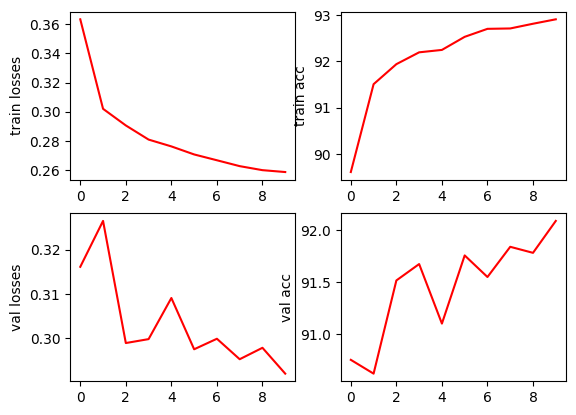

In [57]:
# plot stuff - reuse this cell for plotting bonus material too.
f, axs = plt.subplots(2,2)
axs[0,0].plot(np.arange(len(sgd_train_losses)),sgd_train_losses, 'red')
axs[0,0].plot(np.arange(len(opt_train_losses)),opt_train_losses, 'blue')
axs[0,0].plot(np.arange(len(adam_train_losses)),adam_train_losses, 'black')
axs[0,0].set_ylabel('train losses')
axs[0,1].plot(np.arange(len(sgd_train_acc)),sgd_train_acc, 'red')
axs[0,1].plot(np.arange(len(opt_train_acc)),opt_train_acc, 'blue')
axs[0,1].plot(np.arange(len(adam_train_acc)),adam_train_acc, 'black')
axs[0,1].set_ylabel('train acc')
axs[1,0].plot(np.arange(len(sgd_val_losses)),sgd_val_losses, 'red')
axs[1,0].plot(np.arange(len(opt_val_losses)),opt_val_losses, 'blue')
axs[1,0].plot(np.arange(len(adam_val_losses)),adam_val_losses, 'black')
axs[1,0].set_ylabel('val losses')
axs[1,1].plot(np.arange(len(sgd_val_acc)),sgd_val_acc, 'red')
axs[1,1].plot(np.arange(len(opt_val_acc)),opt_val_acc, 'blue')
axs[1,1].plot(np.arange(len(adam_val_acc)),adam_val_acc, 'black')
axs[1,1].set_ylabel('val acc')

torch.Size([784, 10])


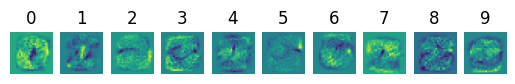

In [ ]:
# We can visualise the learnt weights (one for each class) as images by reshapeing into 28x28 grids

w_cpu = w.cpu().clone()
print(w_cpu.size())

f, axs = plt.subplots(1,number_of_classes)

for k in range(h):
  img = w_cpu[:,k].view(28,28)
  axs[k].imshow(img)
  axs[k].set_title(k)
  axs[k].axis("off")

**###Optional###** -  Other optimisers and Adam

**###Optinional### Question 5** implement your some of the optimisers form ex1 and see how they perfrom in this setting? What differences do you notice?

In [ ]:
with torch.no_grad(): # in this exersize we will not use autograd you will have calucated gradent

  # fixing a device to run the codes on
  device = torch.device("cuda:0")

  w = torch.zeros(input_dimension,number_of_classes).to(device)
  m = torch.zeros(input_dimension,number_of_classes).to(device)

  eta = 1e-1
  num_epochs = 10

  for i in range(num_epochs):
    total_loss, total_correct, total_num = 0, 0, 0
    for batch in train_loader:
      #extractign data and labels from batch
      X,y = batch[0].to(device).view(batch[0].size()[0],input_dimension), batch[1].to(device)
      Y = index_to_one_hot(y, classes=10)
      # ----------------------------
      # Optimisation -  Your code here




      # ----------------------------
      # track loss and accuracy after every step
      loss_train = CE_loss(X, Y, w)
      correct, acc = accuracy(X.mm(w), y)
      total_correct += correct
      total_loss += loss_train*X.size()[0]
      total_num += X.size()[0]

    # ----------------------------
    # After each epoch track metrics
    opt_train_losses.append(float(total_loss/total_num))
    opt_train_acc.append(float(total_correct/total_num * 100))
    val_loss, val_acc = test(w, valid_loader)
    opt_val_losses.append(val_loss)
    opt_val_acc.append(val_acc)
    print('train loss: {:.2e} | train acc: {:.2f} | eta: {:.2f}'.format(float(total_loss/total_num), float(total_correct/total_num * 100), eta))
    print('val loss: {:.2e} | val acc: {:.2f}'.format(val_loss, val_acc))
    print('-'*50)
    # ----------------------------
    # Adjust the learning rate
    eta *= 0.9

**Adam** The Adam optimiser is an adeptive gradient method that uses exponial moving averages of previous gradients to estimates a good step size for each parameter. Thus it avoids the need for a learning rate schedule.

remember $\mathbf{m}$, $\mathbf{v}$ and $\mathbf{w}$ are vectors.

\begin{align*}
  \hat{\mathbf{m}_k} &= \frac{\mathbf{m}_k}{1-\beta_1^t},\hspace{0.1cm} \mathbf{m}_k \leftarrow \beta_1 \mathbf{m}_{k-1} + (1-\beta_1)\nabla \ell_{z_t}(\mathbf{w}_t) \\
  \hat{\mathbf{v}}_k &= \frac{\mathbf{v}_k}{1-\beta_2^t},\hspace{0.1cm} \mathbf{v}_k \leftarrow \beta_2 \mathbf{v}_{k-1} + (1-\beta_2)\nabla \ell_{z_t}(\mathbf{w}_t)^2 \\
  \mathbf{w}_{k+1} &\leftarrow \mathbf{w}_{k} - \frac{\eta}{\sqrt{\hat{\mathbf{v}}_k}+\epsilon} \hat{\mathbf{m}}_k \\
\end{align*}




**###Optinional### Question 6** implement the ADAM optimiser with $\beta_1 = 0.9$,$\beta_2 = 0.999$, $\eta=0.001$ and run MNIST data set.

In [ ]:
with torch.no_grad(): # in this exersize we will not use autograd you will have calucated gradent

  # fixing a device to run the codes on
  device = torch.device("cuda:0")

  w = torch.zeros(input_dimension,number_of_classes).to(device)
  m = torch.zeros(input_dimension,number_of_classes).to(device)

  eta = 1e-3
  beta_1 = 0.9
  beta_2 = 0.999
  num_epochs = 10

  for i in range(num_epochs):
    total_loss, total_correct, total_num = 0, 0, 0
    for batch in train_loader:
      #extractign data and labels from batch
      X,y = batch[0].to(device).view(batch[0].size()[0],input_dimension), batch[1].to(device)
      Y = index_to_one_hot(y, classes=10)
      # ----------------------------
      # Optimisation -  Your code here




      # ----------------------------
      # track loss and accuracy after every step
      loss_train = CE_loss(X, Y, w)
      correct, acc = accuracy(X.mm(w), y)
      total_correct += correct
      total_loss += loss_train*X.size()[0]
      total_num += X.size()[0]

    # ----------------------------
    # After each epoch track metrics
    adam_train_losses.append(float(total_loss/total_num))
    adam_train_acc.append(float(total_correct/total_num * 100))
    val_loss, val_acc = test(w, valid_loader)
    adam_val_losses.append(val_loss)
    adam_val_acc.append(val_acc)
    print('train loss: {:.2e} | train acc: {:.2f} | eta: {:.2f}'.format(float(total_loss/total_num), float(total_correct/total_num * 100), eta))
    print('val loss: {:.2e} | val acc: {:.2f}'.format(val_loss, val_acc))
    print('-'*50)